In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from cycler import cycler
from math import floor

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

# Problem set-up

In [2]:
# numeric parameters of the system
m = 1.
k = 100.
c = 5.
g = 10.
h = .02

In [3]:
# discretization method
method = 'zero_order_hold'

# dynamics n.1 (ball in the air)
A1 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [0., 0., 0.]
    ])
B1 = np.array([[0.], [1.], [0.]])
c1 = np.array([0., 0., -g])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# dynamics n.3 (paddle pushing ball)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A3 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [-k/m, k/m, -c/m]
    ])
B3 = np.array([[0.], [1.], [c/m]])
S3 = LinearSystem.from_continuous(A3, B3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

In [4]:
# state bounds
x_max = np.array([1., .1, 4.])
x_min = np.array([-.3, -.1, -4.])
f_max = 4.*m*g

# input bounds
u_max = np.array([.3])
u_min = - u_max

# domain bounds
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

# domain n.1
# (out of contact when q_ball - q_paddle > m*g/k)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_inequality(
    np.array([[-1., 1., 0., 0.]]),
    np.array([-m*g/k])
)
assert D1.bounded
assert not D1.empty

# domain n.2
# (pulling when q_ball - q_paddle < m*g/k
# and f = k (qp - qb) + c (qpd - qbd) + m g < 0)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_inequality(
    np.array([[1., -1., 0., 0.]]),
    np.array([m*g/k])
)
D2.add_inequality(
    np.array([[-k, k, -c, c]]),
    np.array([-m*g])
)
assert D2.bounded
assert not D2.empty

# domain n.3
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_inequality( # penetration > 0
    np.array([[1., -1., 0., 0.]]),
    np.array([m*g/k])
)
D3.add_inequality( # not pulling
    np.array([[k, -k, c, -c]]),
    np.array([m*g])
)
D3.add_inequality( # maximum force < 5 m g
    np.array([[-k, k, -c, c]]),
    np.array([f_max - m*g])
)
assert D3.bounded
assert not D3.empty

# list of domains
D_list = [D1, D2, D3]

In [5]:
# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

# controller parameters
N = 80
Q = np.diag([5.,50.,.1])
R = np.diag([10.])

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(*[np.zeros(3)]*2)

# Comparison of the different formulations

In [6]:
# initial condition
x0 = np.array([1., .0, .0])

# MI formulations
methods = [
    'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]

## With Gurobi

In [10]:
# solve MICP with all the methods
solves = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
#     controller.add_reachability_constraints(8)
    controller.prog.setParam('OutputFlag', 0.)
#     controller.prog.setParam('Heuristics', 0.)
#     controller.prog.setParam('MIPGap', 0.)
    u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
    solves[method] = {
        'time': controller.prog.Runtime,
        'nodes': controller.prog.NodeCount
    }
    print cost_mip
    
# print solution times and nodes
for method in methods:
    print method
    print 'Solution time:', solves[method]['time']
    print 'Explored nodes:', solves[method]['nodes']

Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Optimize a model with 5606 rows, 1283 columns and 13926 nonzeros
Model has 323 quadratic objective terms
Variable types: 1043 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 3692 rows and 520 columns
Presolve time: 0.03s
Presolved: 1914 rows, 763 columns, 6260 nonzeros
Presolved model has 276 quadratic objective terms
Variable types: 642 continuous, 121 integer (121 binary)

Root relaxation: objective 5.141554e+01, 1369 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   

 746051 133758   54.78273   51   12   55.83324   54.74828  1.94%  17.9  420s
 750047 133460   54.81227   49   18   55.83324   54.74955  1.94%  18.0  425s
 754489 132956 infeasible   51        55.83324   54.75106  1.94%  18.1  430s
 758360 132642   54.87036   45   18   55.83324   54.75219  1.94%  18.1  435s
 762450 132428   54.75308   41   18   55.83324   54.75308  1.93%  18.2  440s
 766231 132025 infeasible   51        55.83324   54.75448  1.93%  18.3  445s
 770181 131719   54.75572   47   16   55.83324   54.75572  1.93%  18.4  450s
 774452 131215   54.75695   42   20   55.83324   54.75695  1.93%  18.5  455s
 778567 130862 infeasible   51        55.83324   54.75855  1.92%  18.5  460s
 782463 130598     cutoff   52        55.83324   54.75981  1.92%  18.6  465s
 786275 130161     cutoff   49        55.83324   54.76111  1.92%  18.7  470s
 789855 129906   54.92796   53   14   55.83324   54.76222  1.92%  18.7  475s
 793612 129536   55.65606   53   10   55.83324   54.76343  1.92%  18.8  480s

 27478  2231     cutoff   31        55.83324   55.58688  0.44%  68.6   80s
 28666  1810     cutoff   28        55.83324   55.63588  0.35%  69.7   86s
 29680  1175     cutoff   26        55.83324   55.69892  0.24%  70.9   90s

Cutting planes:
  Implied bound: 5
  MIR: 5
  Flow cover: 9

Explored 31237 nodes (2248117 simplex iterations) in 94.66 seconds
Thread count was 4 (of 4 available processors)

Solution count 10: 55.8332 55.8349 55.8468 ... 56.1106

Optimal solution found (tolerance 1.00e-04)
Best objective 5.583324314735e+01, best bound 5.583324314735e+01, gap 0.0000%
55.8332431474
Convex hull, lifted constraints
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Optimize a model with 5467 rows, 3452 columns and 15476 nonzeros
Model has 240 quadratic constraints
Variable types: 3212 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  QMatrix range    [5e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bound

In [ ]:
# plot state trajectory
plt.rc('font', size=16)
time = range(N+1)
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.set_xlim([0,N])
ax1.grid(True)

# position of the ball and the paddle (x1 and x3)
x1_plot = ax1.plot(time, [x_t[0] for x_t in x_mip], 'b-', label=r'$x_1$', linewidth=3)
x2_plot = ax1.plot(time, [x_t[1] for x_t in x_mip], 'b-.', label=r'$x_2$', linewidth=3)
x12_lim = max([-x_min[0], x_max[0], -x_min[1], x_max[1]])
ax1.set_ylim([-x12_lim, x12_lim])
ax1.set_ylabel(r'$x_1, x_2$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# velocity of the ball (x2)
ax2 = ax1.twinx()
x3_plot = ax2.plot(time, [x_t[2] for x_t in x_mip], 'r--', label=r'$x_3$', linewidth=3)
x3_lim = max([-x_min[2],x_max[2]])
ax2.set_ylim([-x3_lim, x3_lim])
ax2.set_ylabel(r'$x_3$', color='r')
ax2.tick_params('y', colors='r')

# plot
x_plot = x1_plot + x2_plot + x3_plot
labels = [xi_plot.get_label() for xi_plot in x_plot]
ax1.legend(x_plot, labels)
plt.savefig('state.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# plot input sequence and contact force
plt.rc('font', size=16)
f = [max(k*(x_mip[t][1]-x_mip[t][0]) + c*(u_mip[t][0]-x_mip[t][2]) + m*g, 0.) for t in range(N)]
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.set_xlim([0,N])
ax1.grid(True)

# input
u_plot = ax1.step(time, [u_mip[0][0]] + [u_t[0] for u_t in u_mip], 'b', linestyle='-', label=r'$u$', linewidth=3)
u_lim = max([-u_min[0], u_max[0]])
ax1.set_ylim([-u_lim, u_lim])
ax1.set_ylabel(r'$u$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# force
ax2 = ax1.twinx()
f_plot = ax2.step(time, [f[0]] + [f_t for f_t in f], 'r', linestyle='-.', label=r'$f \ (x,u)$', linewidth=3)
ax2.set_ylim([0, f_max])
ax2.set_ylabel(r'$f \ (x,u)$', color='r')
ax2.tick_params('y', colors='r')

# plot
fu_plot = u_plot + f_plot
labels = [fui_plot.get_label() for fui_plot in fu_plot]
ax1.legend(fu_plot, labels)
# plt.savefig('input_force.pdf', bbox_inches='tight')
plt.show()

## With my branch and bound

In [2]:
from pympc.control.hybrid_benchmark.branch_and_bound import branch_and_bound, best_first

In [3]:
def solver(identifier, objective_cutoff):
    return controller.solve_relaxation(x0, identifier, objective_cutoff)

In [ ]:
lb = {}
ub = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    sol, lb_i, ub_i = branch_and_bound(solver, best_first, controller.explore_in_chronological_order)
    lb[method] = lb_i
    ub[method] = ub_i
# np.save('lb', lb)
# np.save('ub', ub)

In [4]:
# upload
lb = np.load('lb.npy').item()
ub = np.load('ub.npy').item()

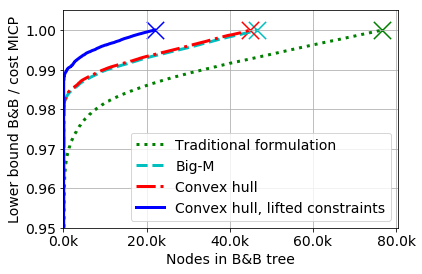

In [10]:
# format x axis to write nk instead of n000
from matplotlib.ticker import FuncFormatter
def thousands(x, pos):
    return '%1.1fk' % (x*1e-3)
formatter = FuncFormatter(thousands)

mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)
colors = ['g', 'c', 'r','b']
linestyles = [':', '--', '-.', '-']
for i, method in enumerate(methods):
    plt.plot(lb[method]/max(lb[method]), label=method, color=colors[i], linestyle=linestyles[i], linewidth=3)
#     plt.plot(ub[method]/min(ub[method]), color=colors[i], linestyle=linestyles[i], linewidth=3,zorder=0)
    plt.scatter(len(lb[method]), 1, color=colors[i], marker='x', s=300)

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
    
plt.xlim((0, 1.05*max([len(lb[method]) for method in methods])))
plt.ylim((.95, 1.005))
plt.legend()
plt.grid(True)
plt.xlabel(r'Nodes in B&B tree')
plt.ylabel(r'Lower bound B&B / cost MICP')
# plt.savefig('relaxation_ratio.pdf', bbox_inches='tight')
plt.show()

# Compare formulations for different levels of relaxation

In [ ]:
# cost of each relaxation as a function of time
costs = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
#     controller.add_reachability_constraints()
    costs[method] = []
    for ms in [ms_mip[:i] for i in range(N+1)]:
        cost = controller.solve_relaxation(x0, ms)[3]['objective']
        if cost is not None:
            cost /= cost_mip
        costs[method].append(cost)

In [ ]:
# plot cost of relaxed problem / cost MICP
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)
colors = ['g', 'c', 'r','b']
linestyles = [':', '--', '-.', '-']
for i, method in enumerate(methods):
    plt.plot(range(N+1), costs[method], label=method, color=colors[i], linestyle=linestyles[i], linewidth=3)
plt.xlim((0, N))
plt.ylim((0, 1.1))
plt.legend()
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'Cost relaxed problem / cost MICP')
# plt.savefig('relaxation_ratio.pdf', bbox_inches='tight')
plt.show()

# Objective as a function of the initial state ($x_1$ and $x_3$ only)

In [ ]:
# samples for the initial position and velocity of the ball
q_p = 0.
n_levels = 10
n_samples = 101
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)

In [ ]:
# utils for the plots

def my_round(x):
    return floor(x*10.)/10.

def get_neighbors(M, i, j):
    return [
        M[i+1, j-1],
        M[i+1,   j],
        M[i+1, j+1],
        M[  i, j+1],
        M[i-1, j+1],
        M[i-1,   j],
        M[i-1, j-1],
        M[  i, j-1]
    ]

def fill_holes_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            if np.isnan(cost_mat[i,j]):
                neighbors = get_neighbors(cost_mat, i, j)
                if not any([np.isnan(n) for n in neighbors]):
                    print 'Filled', (i,j) 
                    cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

def regularize_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            neighbors = get_neighbors(cost_mat, i, j)
            if all([cost_mat[i,j] > n for n in neighbors]):
                print 'Regularized', (i,j) 
                cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

In [ ]:
# solve relaxations for all MI formulations
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    
    # get feasible sets (uses the feasible set of the CH method for the CHLC method)
    if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
        cs = get_constraint_set(controller.prog)
        var_indices = {v: i for i, v in enumerate(controller.prog.getVars())}
        v_index = var_indices[controller.prog.getVarByName('x0[1]')]
        A_sect = cs.A[:, [i for i in range(cs.A.shape[1]) if i != v_index]]
        b_sect = cs.b - cs.A[:, v_index]*q_p
        cs_sect = Polyhedron(A_sect, b_sect)
        sect = convex_hull_method_fast(cs_sect, [0,1])
        
    # samples on the grid
    cost_mat = np.empty([n_samples]*2)
    for i, q_b in enumerate(q_b_samples):
        for j, v_b in enumerate(v_b_samples):
            print(str(i) + ',' + str(j) + '   \r'),
            x0 = np.array([q_b,q_p,v_b])
            cost = controller.feedforward_relaxation(x0, [])[3]
            cost_mat[i,j] = cost
    
#     # save data
#     np.save(method + '_feasible_set_A', sect.A)
#     np.save(method + '_feasible_set_b', sect.b)
#     np.save(method, cost_mat)

In [ ]:
# plot cost and feasible set
plt.rc('font', size=14)
for method in methods:
#     cost_mat = np.load(method + '.npy')
#     if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
#         A = np.load(method + '_feasible_set_A.npy')
#         b = np.load(method + '_feasible_set_b.npy')
#         sect = Polyhedron(A, b)
    levels = [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
    cp = plt.contour(Q_b, V_b, cost_mat.T, levels=levels, cmap='viridis_r')
    plt.colorbar(cp, label='Cost relaxed problem')
    sect.plot(facecolor='w')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_3$')
    plt.title(method)
    plt.grid(True)
#     plt.savefig(method + '.pdf',bbox_inches='tight')
    plt.savefig('new_ch.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
# solve MICP on the grid (COMMENT prog.reset() BEFORE RUNNING THIS!!!)
cost_mat = np.empty([n_samples]*2)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Big-M')
controller.prog.setParam('OutputFlag', 0)
controller.prog.setParam('MIPGap', 0.01)
controller.prog.setParam('TimeLimit', 1200.)
time_limits = 0
for i, q_b in enumerate(q_b_samples):
    for j, v_b in enumerate(v_b_samples):
        print(str(i) + ',' + str(j) + ',' + str(time_limits) + '    \r'),
        x0 = np.array([[q_b],[q_p],[v_b]])
        cost = controller.feedforward(x0)[3]
        cost_mat[i,j] = cost
        if controller.prog.status == 9:
            time_limits += 1
            
# # save data
# np.save('q_b_samples', q_b_samples)
# np.save('v_b_samples', v_b_samples)
# np.save('cost_mat_miqp', cost_mat)

In [ ]:
# plot cost MICP
plt.rc('font', size=14)
cost_mat = np.load('cost_mat_miqp.npy')
cost_mat = fill_holes_cost_mat(cost_mat)
cost_mat = regularize_cost_mat(cost_mat)
n_levels = 9
levels = [0.] + [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
cp = plt.contourf(Q_b, V_b, cost_mat.T, levels=levels, cmap='viridis_r')
plt.grid(True)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.colorbar(cp, label='Cost MICP')
plt.grid(True)
# plt.savefig('cost_mat_miqp.pdf',bbox_inches='tight')
plt.show()